In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from src.rover_sim.rover_updated import *
from src.rover_sim.terrain import *

In [3]:
# Set up ALPaCA
%load_ext autoreload
%autoreload 2

# # Can change to arbitrary dynamics object, as long as the model being loaded corresponds to it
from src.envs.rocker_bogie_with_terrain_simplified import RockerBogieDynamics as Dynamics
from src.envs.rocker_bogie_with_terrain_simplified import state_space, action_space

from src.models import Alpaca, AlpacaDynamics
from src.models.dataset import DynamicsRandomDataset

from src.utils.validation import action_sweep, state_sweep, single_action

In [4]:
# create ground truth dynamics to compare to
dynamics = Dynamics()
dynamics.seed(1234)

c rand
phi rand


[1234]

In [5]:
# Set up ALPaCA dyn_fns

# These params shouldn't change
# Loose Sand parameters
# n = 1.1; k_c = 0.9e3; k_phi = 1523.4e3; k = 0.025; c1 = 0.18; c2 = 0.32 

# Compact sand parameters 
n = 0.47; k_c = 0.9e3; k_phi = 1523.4e3; k = 0.038; c1 = 0.43; c2 = 0.32 

c_placeholder = 0.9e3 
phi_placeholder = np.deg2rad(30) 
terr_params = [c_placeholder, phi_placeholder, n, k, k_c, k_phi, n, c1, c2] 
dt = 0.1

filename = './trained_models/rocker_bogie_alp_alone'
### NO NOMINAL MODEL, ALPaCA alone
alpaca_model_alone = AlpacaDynamics(Alpaca(model_path=filename).float())
dyn_fn_alpaca_alone = alpaca_model_alone.get_model(modeltype=alpaca_model_alone.ModelType.POSTERIOR_PREDICTIVE)

filename = './trained_models/rocker_bogie_alp_nom'
### WITH NOMINAL MODEL broken up (simplified) only velocity
fnom = lambda x,u: dynamics.rover.get_fnom_function_vel_only(x, u, terr_params, dt)
phi_nom_fn=lambda x,u: dynamics.rover.get_c_tanphi_features_matrix_vel_only(x,u, terr_params, dt)
model = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_with_nom = AlpacaDynamics(model, f_nom=fnom)
dyn_fn_alpaca_with_nom = alpaca_model_with_nom.get_model(modeltype=alpaca_model_with_nom.ModelType.POSTERIOR_PREDICTIVE)

filename = './trained_models/rocker_bogie_alp_ortho'
### WITH NOMINAL MODEL broken up (simplified) only velocity - orthogonal loss term
fnom = lambda x,u: dynamics.rover.get_fnom_function_vel_only(x, u, terr_params, dt)
phi_nom_fn=lambda x,u: dynamics.rover.get_c_tanphi_features_matrix_vel_only(x,u, terr_params, dt)
model = Alpaca(model_path=filename, phi_nom_fn=phi_nom_fn, num_aug_features=2).float()
alpaca_model_ortho = AlpacaDynamics(model, f_nom=fnom)
dyn_fn_alpaca_ortho = alpaca_model_ortho.get_model(modeltype=alpaca_model_ortho.ModelType.POSTERIOR_PREDICTIVE)


loading state dict
loading state dict
loading state dict


## Set up default rover geometry, inertias, terrain

In [6]:
rover = makeDefaultRover()
rover.set_terrain(FlatTerrain())

# Predicting dynamics 

In [7]:
state_init = np.array([0.0])
prev_slips = np.array([0.001,0.001,0.001])
prev_sinkages = np.array([0.02,0.02,0.02])

dt = 0.1


In [8]:
N_sim_steps = 50
torques_list = rover.get_random_torques(N_sim_steps, two_phase=True)

full_action_list = np.zeros((N_sim_steps, 9))
u_list = np.zeros((N_sim_steps, 6)) # slips and sinks only

# True model
xp_vel_only = np.zeros((N_sim_steps+1, 1))
xp_vel_only[0,:] = state_init
# Linear model
xp_lin = np.zeros((N_sim_steps+1, 1))
xp_lin[0,:] = state_init
# True distribution
xp_true_mean = np.zeros((N_sim_steps+1, 1))
xp_true_mean[0,:] = state_init
xp_true_std = np.zeros((N_sim_steps+1, 1))
# ALPaCA alone
xp_alpaca_mean = np.zeros((N_sim_steps+1, 1))
xp_alpaca_mean[0,:] = state_init
xp_alpaca_std = np.zeros((N_sim_steps+1, 1))
# ALPaCA + lin
xp_alpnom_mean = np.zeros((N_sim_steps+1, 1))
xp_alpnom_mean[0,:] = state_init
xp_alpnom_std = np.zeros((N_sim_steps+1, 1))
# ALPaCA + lin (ortho)
xp_alportho_mean = np.zeros((N_sim_steps+1, 1))
xp_alportho_mean[0,:] = state_init
xp_alportho_std = np.zeros((N_sim_steps+1, 1))

# reset the alpaca models
alpaca_model_alone.reset()
alpaca_model_with_nom.reset()
alpaca_model_ortho.reset()

# gather params
# alpaca alone
stats = alpaca_model_alone.model.prior_params()
Q, L = stats 
Kbar = (torch.inverse(L) @ Q)
phi_dim = 64
alpaca_params = np.zeros((N_sim_steps+1, phi_dim))
alpaca_params[0,:] = Kbar.detach().numpy().squeeze()
alpaca_var = np.zeros((N_sim_steps+1, phi_dim, phi_dim))
alpaca_var[0,:] = L.detach().numpy().squeeze()

# alpaca + lin
stats = alpaca_model_with_nom.model.prior_params()
Q, L = stats 
Kbar = (torch.inverse(L) @ Q)
phi_dim_alpanom = 66
alpaca_nom_params = np.zeros((N_sim_steps+1, phi_dim_alpanom))
alpaca_nom_params[0,:] = Kbar.detach().numpy().squeeze()
alpaca_nom_var = np.zeros((N_sim_steps+1, phi_dim_alpanom, phi_dim_alpanom))
alpaca_nom_var[0,:] = L.detach().numpy().squeeze()

# alpaca + lin (ortho)
stats = alpaca_model_ortho.model.prior_params()
Q, L = stats 
Kbar = (torch.inverse(L) @ Q)
phi_dim_alportho = 66
alpaca_ortho_params = np.zeros((N_sim_steps+1, phi_dim_alportho))
alpaca_ortho_params[0,:] = Kbar.detach().numpy().squeeze()
alpaca_ortho_var = np.zeros((N_sim_steps+1, phi_dim_alportho, phi_dim_alportho))
alpaca_ortho_var[0,:] = L.detach().numpy().squeeze()

# True parameters
c_true = 0.69e3
phi_true = np.deg2rad(33)
terr_params_true = [c_true, phi_true, n, k, k_c, k_phi, n, c1, c2]

# Linear model (loose sand) parameters
c_for_pred = 1e3 
phi_for_pred = np.deg2rad(45) 
terr_params_for_lin_predicion = [c_for_pred, phi_for_pred, n, k, k_c, k_phi, n, c1, c2]

state_curr = state_init
for step in range(N_sim_steps):
        # Simulate a step using true params
        full_action = rover.get_full_action_vel_only(state_curr, torques_list[step,:], terr_params_true, prev_slips, prev_sinkages)
        u = full_action[3:9]
        u_list[step,:] = u
        state_new = rover.transition_vel_only(state_curr, u, terr_params_true, dt)
        xp_vel_only[step+1,:] = state_new

        noise = 0.01
        state_new_for_alpaca = state_new + noise*np.random.randn(*state_new.shape)

        # Get linear model predictions
        xp_lin[step+1,:] = rover.predict_dynamics_lin_model_vel_only(state_curr, u, terr_params_for_lin_predicion, dt)

        # Get alpaca only predictions
        xp_true_mean[step+1,:], xp_true_std[step+1,:], xp_alpaca_mean[step+1,:], xp_alpaca_std[step+1,:] = single_action(dyn_fn_alpaca_alone, dynamics, state_curr, u)
        stats = alpaca_model_alone.incorporate_transition(state_curr, u, state_new_for_alpaca)
        dyn_fn_alpaca_alone = alpaca_model_alone.get_model(modeltype=alpaca_model_alone.ModelType.POSTERIOR_PREDICTIVE)
        Q, L = stats
        Kbar = (torch.inverse(L) @ Q)
        alpaca_params[step+1,:] = Kbar.detach().numpy().squeeze()
        alpaca_var[step+1,:] = L.detach().numpy().squeeze()

        # Get alpaca nom predictions
        xp_true_mean[step+1,:], xp_true_std[step+1,:], xp_alpnom_mean[step+1,:], xp_alpnom_std[step+1,:] = single_action(dyn_fn_alpaca_with_nom, dynamics, state_curr, u)
        stats = alpaca_model_with_nom.incorporate_transition(state_curr, u, state_new_for_alpaca)
        dyn_fn_alpaca_with_nom = alpaca_model_with_nom.get_model(modeltype=alpaca_model_with_nom.ModelType.POSTERIOR_PREDICTIVE)
        Q, L = stats
        Kbar = (torch.inverse(L) @ Q)
        alpaca_nom_params[step+1,:] = Kbar.detach().numpy().squeeze()
        alpaca_nom_var[step+1,:] = L.detach().numpy().squeeze()

        # Get alpaca ortho predictions
        xp_true_mean[step+1,:], xp_true_std[step+1,:], xp_alportho_mean[step+1,:], xp_alportho_std[step+1,:] = single_action(dyn_fn_alpaca_ortho, dynamics, state_curr, u)
        stats = alpaca_model_ortho.incorporate_transition(state_curr, u, state_new_for_alpaca)
        dyn_fn_alpaca_ortho = alpaca_model_ortho.get_model(modeltype=alpaca_model_ortho.ModelType.POSTERIOR_PREDICTIVE)
        Q, L = stats
        Kbar = (torch.inverse(L) @ Q)
        alpaca_ortho_params[step+1,:] = Kbar.detach().numpy().squeeze()
        alpaca_ortho_var[step+1,:] = L.detach().numpy().squeeze()

        state_curr = state_new

# Load saved data

In [9]:
import pickle
# Load data to save time
filename = './stored_results/results_for_pred_dyn_loose.pickle'
with open(filename, 'rb') as f:
    xp_vel_only, xp_lin, xp_alpaca_mean, xp_alpaca_std, xp_alpnom_mean, xp_alpnom_std, xp_alportho_mean, xp_alportho_std = pickle.load(f)

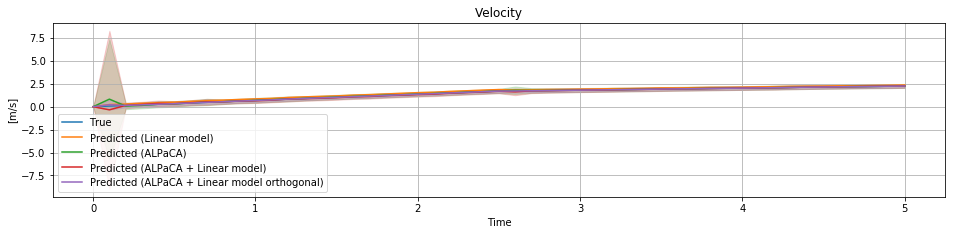

In [10]:
times = dt*np.arange(N_sim_steps+1)

fig = plt.figure(figsize= plt.figaspect(0.2))

ax1 = fig.add_subplot(111)
ax1.plot(times, xp_vel_only[:,:],  label ='True')

ax1.plot(times, xp_lin[:,:], label ='Predicted (Linear model)')

ax1.plot(times, xp_alpaca_mean[:,0], color = 'C2', label ='Predicted (ALPaCA)')
ax1.fill_between(times, xp_alpaca_mean[:,0] - 1.96*xp_alpaca_std[:,0], xp_alpaca_mean[:,0] + 1.96*xp_alpaca_std[:,0], color='C2', alpha=0.2)

ax1.plot(times, xp_alpnom_mean[:,0], color = 'C3', label ='Predicted (ALPaCA + Linear model)')
ax1.fill_between(times, xp_alpnom_mean[:,0] - 1.96*xp_alpnom_std[:,0], xp_alpnom_mean[:,0] + 1.96*xp_alpnom_std[:,0], color='C3', alpha=0.2)

ax1.plot(times, xp_alportho_mean[:,0], color = 'C4', label ='Predicted (ALPaCA + Linear model orthogonal)')
ax1.fill_between(times, xp_alportho_mean[:,0] - 1.96*xp_alportho_std[:,0], xp_alportho_mean[:,0] + 1.96*xp_alportho_std[:,0], color='C4', alpha=0.2)

# ax1.plot(times, xp_true_mean[:,0], color = 'C5', label ='True distribution')
# ax1.fill_between(times, xp_true_mean[:,0] - 1.96*xp_true_std[:,0], xp_true_mean[:,0] + 1.96*xp_true_std[:,0], color='C5', alpha=0.2)
ax1.set(title = 'Velocity', xlabel = 'Time', ylabel = '[m/s]')
ax1.legend(loc = 'best')
ax1.grid()

plt.show()

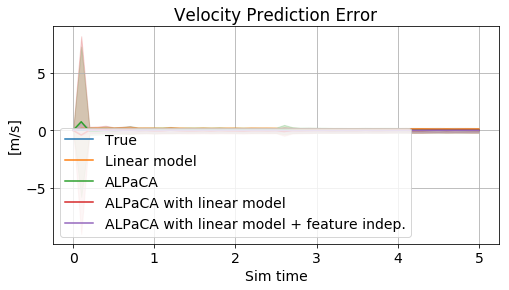

In [11]:
times = dt*np.arange(N_sim_steps+1)

fig = plt.figure(figsize= plt.figaspect(0.5))
plt.rcParams.update({'font.size': 14})

ax1 = fig.add_subplot(111)
ax1.plot(times, xp_vel_only[:,:] - xp_vel_only[:,:],  label ='True')

ax1.plot(times, xp_lin[:,:]- xp_vel_only[:,:], label ='Linear model')

ax1.plot(times, xp_alpaca_mean[:,:]- xp_vel_only[:,:], color = 'C2', label ='ALPaCA')
ax1.fill_between(times, xp_alpaca_mean[:,0]- xp_vel_only[:,0] - 1.96*xp_alpaca_std[:,0], xp_alpaca_mean[:,0]- xp_vel_only[:,0] + 1.96*xp_alpaca_std[:,0], color='C2', alpha=0.2)

ax1.plot(times, xp_alpnom_mean[:,0]- xp_vel_only[:,0], color = 'C3', label ='ALPaCA with linear model')
ax1.fill_between(times, xp_alpnom_mean[:,0]- xp_vel_only[:,0] - 1.96*xp_alpnom_std[:,0], xp_alpnom_mean[:,0]- xp_vel_only[:,0] + 1.96*xp_alpnom_std[:,0], color='C3', alpha=0.2)

ax1.plot(times, xp_alportho_mean[:,0]- xp_vel_only[:,0], color = 'C4', label ='ALPaCA with linear model + feature indep.')
ax1.fill_between(times, xp_alportho_mean[:,0]- xp_vel_only[:,0] - 1.96*xp_alportho_std[:,0], xp_alportho_mean[:,0]- xp_vel_only[:,0] + 1.96*xp_alportho_std[:,0], color='C4', alpha=0.2)

# ax1.plot(times, xp_true_mean[:,0]- xp_vel_only[:,:], color = 'C5', label ='True distribution')
# ax1.fill_between(times, xp_true_mean[:,0] - xp_vel_only[:,:]- 1.96*xp_true_std[:,0], xp_true_mean[:,0]- xp_vel_only[:,:] + 1.96*xp_true_std[:,0], color='C5', alpha=0.2)
ax1.set(title = 'Velocity Prediction Error', xlabel = 'Sim time', ylabel = '[m/s]')
ax1.legend(loc = 'best')
# ax1.set_ylim([-0.8,0.5])
ax1.grid()

plt.show()

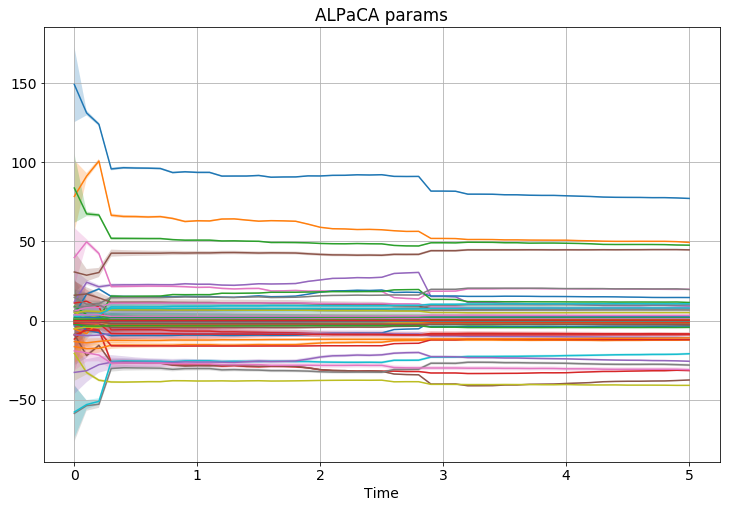

In [12]:
times = dt*np.arange(N_sim_steps+1)

fig = plt.figure(figsize= 2*plt.figaspect(0.3))
ax1 = fig.add_subplot(121)
for i in range(phi_dim):
    ax1.plot(times, alpaca_params[:,i], label='Params')
    ax1.fill_between(times,alpaca_params[:,i] - 1.96/np.sqrt(alpaca_var[:,i,i]), alpaca_params[:,i] + 1.96/np.sqrt(alpaca_var[:,i,i]),alpha=0.25)
        
ax1.set(title = 'ALPaCA params', xlabel = 'Time', ylabel = '')
ax1.grid()

plt.show()

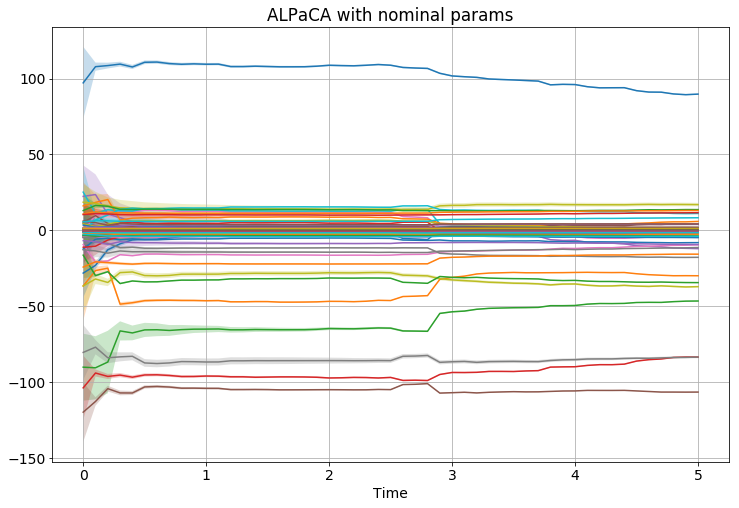

In [13]:
times = dt*np.arange(N_sim_steps+1)

fig = plt.figure(figsize= 2*plt.figaspect(0.3))
ax1 = fig.add_subplot(121)
for i in range(phi_dim_alpanom):
    ax1.plot(times, alpaca_nom_params[:,i], label='Params')
    ax1.fill_between(times,alpaca_nom_params[:,i] - 1.96/np.sqrt(alpaca_nom_var[:,i,i]), alpaca_nom_params[:,i] + 1.96/np.sqrt(alpaca_nom_var[:,i,i]),alpha=0.25)
        
ax1.set(title = 'ALPaCA with nominal params', xlabel = 'Time', ylabel = '')
ax1.grid()

plt.show()

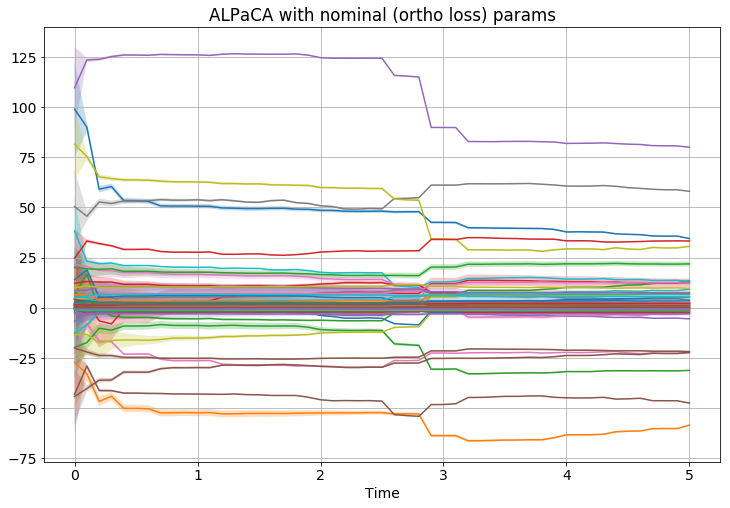

In [14]:
times = dt*np.arange(N_sim_steps+1)

fig = plt.figure(figsize= 2*plt.figaspect(0.3))
ax1 = fig.add_subplot(121)
for i in range(phi_dim_alportho):
    ax1.plot(times, alpaca_ortho_params[:,i], label='Params')
    ax1.fill_between(times,alpaca_ortho_params[:,i] - 1.96/np.sqrt(alpaca_ortho_var[:,i,i]), alpaca_ortho_params[:,i] + 1.96/np.sqrt(alpaca_ortho_var[:,i,i]),alpha=0.25)
        
ax1.set(title = 'ALPaCA with nominal (ortho loss) params', xlabel = 'Time', ylabel = '')
ax1.grid()

plt.show()